In [1]:
import glob
import os
from pathlib import Path
import pickle
import time

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import scipy.io as sio

from nils.reconstruction_module import cleanup_formfactor, master_recon
from nils.simulate_spectrometer_signal import get_crisp_signal
import spectralvd

In [2]:
def current2formfactor(s, current, grating="both"):
    """Convert a current to its corresponding cleaned form factor."""
    frequency, formfactor, formfactor_noise, detlim = get_crisp_signal(s, current, n_shots=10, which_set=grating)
    print(f"{frequency.shape=}")
    clean_frequency, clean_formfactor, _ = cleanup_formfactor(frequency, formfactor, formfactor_noise, detlim, channels_to_remove=[])

    return clean_frequency, clean_formfactor


def center_currents(currents, n_samples=100):
    edges = np.array([spectralvd.find_edges(s, current) for s, current in currents])
    resampled = [spectralvd.resample(s, current, left, right, n_samples) for (s, current), (left, right) in zip(currents, edges)]
    centered = [spectralvd.center_on_zero(s, current, left, right) for (s, current), (left, right) in zip(resampled, edges)]
    return centered


data_files = ["rf_train", "formfactors_train", "currents_train", "rf_test", "formfactors_test", "currents_test"]
if all(os.path.isfile(f"data/{f}.pkl") for f in data_files):
    rf_train, formfactors_train, currents_train, rf_test, formfactors_test, currents_test = [spectralvd.from_pickle(f"data/{f}") for f in data_files]
else:
    with open("ocelot80k.pkl", "rb") as file:
        data = pickle.load(file)
       
    currents = [(sample["s"][:1000], sample["I"][:1000]) for sample in data]
       
    rfparam_keys = ["chirp", "curv", "skew", "l1", "l2", "A1.v", "A1.phi", "AH1.v", "AH1.phi", "L1.v",
                    "L1.phi", "L2.v", "L2.phi"]
    rfparams = [[sample[k] for k in rfparam_keys] for sample in data]
       
    del data
    
    filtered_currents = [(s, current) for s, current in currents if current.max() > 1000]
    filtered_rfparams = [sample for sample, (_, current) in zip(rfparams, currents) if current.max() > 1000]

    formfactors = np.array([current2formfactor(*current, grating="both") for current in filtered_currents])
    
    X = list(zip(filtered_rfparams, formfactors))
    y = filtered_currents
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
       
    rf_train = [rf for rf, _ in X_train]
    formfactors_train = [ff for _, ff in X_train]
    currents_train = y_train
    rf_test = [rf for rf, _ in X_test]
    formfactors_test = [ff for _, ff in X_test]
    currents_test = center_currents(y_test)
    
    Path("data").mkdir(parents=True, exist_ok=True)
    datas = [rf_train, formfactors_train, currents_train, rf_test, formfactors_test, currents_test]
    for f, d in zip(data_files, datas):
       spectralvd.to_pickle(d, f"data/{f}")

### Train different models

In [3]:
model_dir = "models"

In [4]:
path = f"{model_dir}/fixed"
if os.path.isdir(path):
    fixed = spectralvd.Fixed.load(path)
else:
    fixed = spectralvd.Fixed(width=140e-6, n_samples=100)
    fixed.fit(formfactors_train, currents_train, epochs=1000, verbose=0)
    fixed.save(path)

In [5]:
path = f"{model_dir}/annrf"
if os.path.isdir(path):
    annrf = spectralvd.AdaptiveANNRF.load(path)
else:
    annrf = spectralvd.AdaptiveANNRF(n_samples=100)
    annrf.fit(rf_train, currents_train, epochs=1000, verbose=0)
    annrf.save(path)

In [6]:
path = f"{model_dir}/annthz"
if os.path.isdir(path):
    annthz = spectralvd.AdaptiveANNTHz.load(path)
else:
    annthz = spectralvd.AdaptiveANNTHz(n_samples=100)
    annthz.fit(formfactors_train, currents_train, epochs=1000, verbose=0)
    annthz.save(path)

In [7]:
path = f"{model_dir}/annrfthz"
if os.path.isdir(path):
    annrfthz = spectralvd.AdaptiveANNRFTHz.load(path)
else:
    annrfthz = spectralvd.AdaptiveANNRFTHz(n_samples=100)
    annrfthz.fit(rf_train, formfactors_train, currents_train, epochs=1000, verbose=0)
    annrfthz.save(path)

In [8]:
path = f"{model_dir}/knnrf"
if os.path.isdir(path):
    knnrf = spectralvd.AdaptiveKNNRF.load(path)
else:
    knnrf = spectralvd.AdaptiveKNNRF(n_samples=100)
    knnrf.fit(rf_train, currents_train)
    knnrf.save(path)

In [9]:
path = f"{model_dir}/knnthz"
if os.path.isdir(path):
    knnthz = spectralvd.AdaptiveKNNTHz.load(path)
else:
    knnthz = spectralvd.AdaptiveKNNTHz(n_samples=100)
    knnthz.fit(formfactors_train, currents_train)
    knnthz.save(path)

In [10]:
path = f"{model_dir}/knnrfthz"
if os.path.isdir(path):
    knnrfthz = spectralvd.AdaptiveKNNRFTHz.load(path)
else:
    knnrfthz = spectralvd.AdaptiveKNNRFTHz(n_samples=100)
    knnrfthz.fit(rf_train, formfactors_train, currents_train)
    knnrfthz.save(path)

### Example Prediction

In [11]:
def plot_prediction(truth, prediction, labels=None):
    plt.plot(truth[0]*1e6, truth[1]*1e-3, label="Ground Truth")
    prediction = np.array(prediction)
    if prediction.ndim == 2:
        prediction = np.expand_dims(prediction, axis=0)
    for i, pi in enumerate(prediction):
        l = labels[i] if labels is not None else i
        plt.plot(pi[0]*1e6, pi[1]*1e-3, ls="--", label=f"Prediction {l}")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.grid()
    plt.legend()

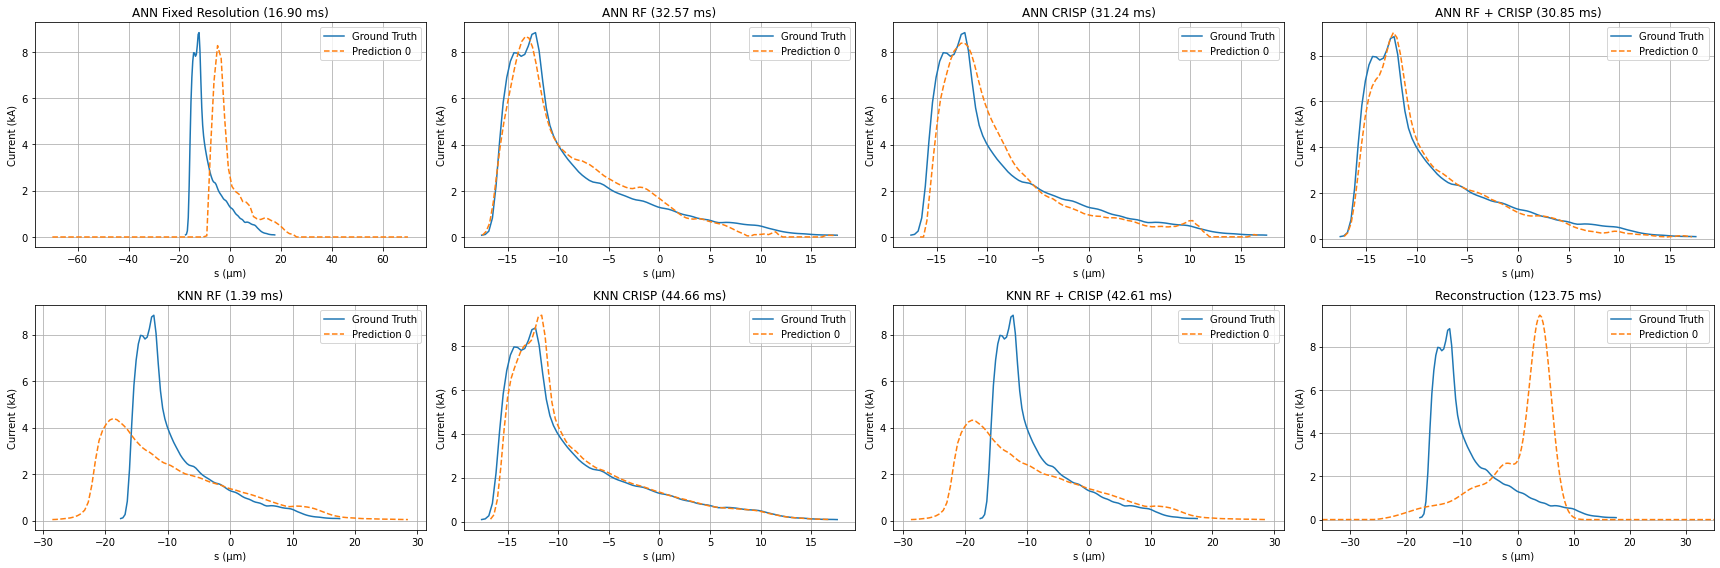

In [42]:
times = {}

sample = 32
# sample = 10
# sample = 131
plt.figure(figsize=(24,8))
plt.subplot(241)
t1 = time.perf_counter()
prediction = fixed.predict(formfactors_test[sample:sample+2])
t2 = time.perf_counter()
td = (t2 - t1) / 2
times["ANN Fixed Resolution"] = td
plt.title(f"ANN Fixed Resolution ({td*1e3:.2f} ms)")
plot_prediction(currents_test[sample], prediction[0].squeeze())
plt.subplot(242)
t1 = time.perf_counter()
prediction = annrf.predict(rf_test[sample:sample+2])
t2 = time.perf_counter()
td = (t2 - t1) / 2
times["ANN RF"] = td
plt.title(f"ANN RF ({td*1e3:.2f} ms)")
plot_prediction(currents_test[sample], prediction[0].squeeze())
plt.subplot(243)
t1 = time.perf_counter()
prediction = annthz.predict(formfactors_test[sample:sample+2])
t2 = time.perf_counter()
td = (t2 - t1) / 2
times["ANN CRISP"] = td
plt.title(f"ANN CRISP ({td*1e3:.2f} ms)")
plot_prediction(currents_test[sample], prediction[0].squeeze())
plt.subplot(244)
t1 = time.perf_counter()
prediction = annrfthz.predict(rf_test[sample:sample+2], formfactors_test[sample:sample+2])
t2 = time.perf_counter()
td = (t2 - t1) / 2
times["ANN RF + CRISP"] = td
plt.title(f"ANN RF + CRISP ({td*1e3:.2f} ms)")
plot_prediction(currents_test[sample], prediction[0].squeeze())
plt.subplot(245)
t1 = time.perf_counter()
prediction = knnrf.predict(rf_test[sample:sample+2])
t2 = time.perf_counter()
td = (t2 - t1) / 2
times["KNN RF"] = td
plt.title(f"KNN RF ({td*1e3:.2f} ms)")
plot_prediction(currents_test[sample], prediction[0].squeeze())
plt.subplot(246)
t1 = time.perf_counter()
prediction = knnthz.predict(formfactors_test[sample:sample+2])
t2 = time.perf_counter()
td = (t2 - t1) / 2
times["KNN CRISP"] = td
plt.title(f"KNN CRISP ({td*1e3:.2f} ms)")
plot_prediction(currents_test[sample], prediction[0].squeeze())
plt.subplot(247)
t1 = time.perf_counter()
prediction = knnrfthz.predict(rf_test[sample:sample+2], formfactors_test[sample:sample+2])
t2 = time.perf_counter()
td = (t2 - t1) / 2
times["KNN RF + CRISP"] = td
plt.title(f"KNN RF + CRISP ({td*1e3:.2f} ms)")
plot_prediction(currents_test[sample], prediction[0].squeeze())
plt.subplot(248)
frequencies, formfactors, formfactor_noise, detlim = get_crisp_signal(currents_test[sample][0], currents_test[sample][1], n_shots=10, which_set="both")
t1 = time.perf_counter()
recon_time, recon_current, t_rms = master_recon(frequencies, formfactors, formfactor_noise, detlim, charge=250e-12,
                                                method="KKstart", channels_to_remove=[], show_plots=False)
t2 = time.perf_counter()
td = t2 - t1
times["Reconstruction"] = td
plt.title(f"Reconstruction ({td*1e3:.2f} ms)")
plot_prediction(currents_test[sample], (recon_time*3e8,recon_current))
plt.xlim(-35, 35)
plt.tight_layout()
plt.show()

### MAE

In [54]:
def compute_mae(truths, predictions, minflip=False):
    maes = []
    for t, p in zip(truths, predictions):
        left = min(t[0].min(), p[0].min())
        right = max(t[0].max(), p[0].max())
        
        new_s = np.linspace(left, right, 100)
        ti = np.interp(new_s, t[0], t[1], left=0, right=0)
        pi = np.interp(new_s, p[0], p[1], left=0, right=0)
        
        mae = np.abs(ti - pi).mean()
        
        if minflip:
            mae2 = np.abs(ti - np.flip(pi)).mean()
            mae = min(mae, mae2)
        
        maes.append(mae)
    
    return np.mean(maes)

In [29]:
model_maes = {}

predictions = fixed.predict(formfactors_test)
predictions = center_currents(predictions)
mae = compute_mae(currents_test, predictions)
model_maes["ANN Fixed Resolution"] = mae

predictions = annrf.predict(rf_test)
mae = compute_mae(currents_test, predictions)
model_maes["ANN RF"] = mae

predictions = annthz.predict(formfactors_test)
mae = compute_mae(currents_test, predictions)
model_maes["ANN CRISP"] = mae

predictions = annrfthz.predict(rf_test, formfactors_test)
mae = compute_mae(currents_test, predictions)
model_maes["ANN RF + CRISP"] = mae

predictions = knnrf.predict(rf_test)
mae = compute_mae(currents_test, predictions)
model_maes["KNN RF"] = mae

predictions = knnthz.predict(formfactors_test)
mae = compute_mae(currents_test, predictions)
model_maes["KNN CRISP"] = mae

predictions = knnrfthz.predict(rf_test, formfactors_test)
mae = compute_mae(currents_test, predictions)
model_maes["KNN RF + CRISP"] = mae

predictions = []
for current in currents_test:
    frequencies, formfactors, formfactor_noise, detlim = get_crisp_signal(current[0], current[1], n_shots=10, which_set="both")
    recon_time, recon_current, t_rms = master_recon(frequencies, formfactors, formfactor_noise, detlim, charge=250e-12,
                                                    method="KKstart", channels_to_remove=[], show_plots=False)
    
    predictions.append((recon_time*3e8, recon_current))
predictions = center_currents(predictions)
mae = compute_mae(currents_test, predictions)
model_maes["Reconstruction"] = mae

In [55]:
predictions = []
for current in currents_test:
    frequencies, formfactors, formfactor_noise, detlim = get_crisp_signal(current[0], current[1], n_shots=10, which_set="both")
    recon_time, recon_current, t_rms = master_recon(frequencies, formfactors, formfactor_noise, detlim, charge=250e-12,
                                                    method="KKstart", channels_to_remove=[], show_plots=False)
    
    predictions.append((recon_time*3e8, recon_current))
predictions = center_currents(predictions)
mae = compute_mae(currents_test, predictions, minflip=True)
model_maes["Reconstruction (Minflip)"] = mae

In [56]:
model_maes

{'ANN Fixed Resolution': 436.2174020780684,
 'ANN RF': 152.4862879429045,
 'ANN CRISP': 357.37033341162135,
 'ANN RF + CRISP': 150.79963801637018,
 'KNN RF': 658.9414913083579,
 'KNN CRISP': 278.599732371298,
 'KNN RF + CRISP': 612.3608806961489,
 'Reconstruction': 1048.7245095361861,
 'Reconstruction (Minflip)': 407.1495869823116}

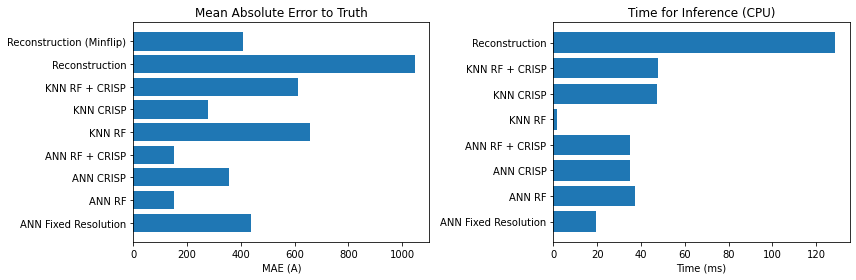

In [70]:
results = [(k, v) for k, v in model_maes.items()]
names = [k for k, _ in results]
values = [v for _, v in results]

results2 = [(k, v) for k, v in times.items()]
names2 = [k for k, _ in results2]
values2 = [v*1e3 for _, v in results2]

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title("Mean Absolute Error to Truth")
plt.barh(names, values)
plt.xlabel("MAE (A)")
plt.subplot(122)
plt.title("Time for Inference (CPU)")
plt.barh(names2, values2)
plt.xlabel("Time (ms)")
plt.tight_layout()
plt.show()

### Test on Real Data from Nils

In [91]:
l1s_real = []
formfactors_real = []
currents_real = []

tds_mat = sio.loadmat("for_jan/TDS/tds_l1_results.mat")
for l1, current in zip(tds_mat["l1"].astype("float64").squeeze(), tds_mat["currents"].astype("float64").squeeze()):
    paths = glob.glob(f"for_jan/CRISP/formfactor_new_*_*_*_l1_{l1:.1f}.mat")
    assert len(paths) == 1
    
    crisp_mat = sio.loadmat(paths[0])
    
    l1s_real.append(l1)
    formfactors_real.append((
        crisp_mat["frequencies"].astype("float64").squeeze(),
        crisp_mat["formfactors"].astype("float64").squeeze(),
        crisp_mat["formfactors_err"].astype("float64").squeeze(),
        crisp_mat["det_lim"].astype("float64").squeeze(),
        float(crisp_mat["charge"].astype("float64").squeeze())
    ))
    currents_real.append((tds_mat["time"].astype("float64").squeeze()*3e8, current))

In [92]:
formfactors_real_clean = [cleanup_formfactor(freq, ff, ff_noise, detlim, channels_to_remove=[])[:2] for freq, ff, ff_noise, detlim, _ in formfactors_real]

In [93]:
def reconstruct_by_nils(frequencies, formfactors, formfactor_noise, detlim, charge):
    recon_time, recon_current, t_rms = master_recon(frequencies, formfactors, formfactor_noise, detlim, charge=charge,
                                                    method="KKstart", channels_to_remove=[], show_plots=False)
    centered = center_currents([(recon_time * 3e8, recon_current)])
    return centered[0]

In [94]:
real_current_predictions_knn = knnthz.predict([(freq, ff) for freq, ff in formfactors_real_clean])
real_current_predictions_ann = annthz.predict([(freq, ff) for freq, ff in formfactors_real_clean])
real_current_predictions_nils = np.array([reconstruct_by_nils(*record) for record in formfactors_real])
real_current_predictions = list(zip(real_current_predictions_knn, real_current_predictions_ann, real_current_predictions_nils))

In [95]:
currents_real_centered = center_currents(currents_real)

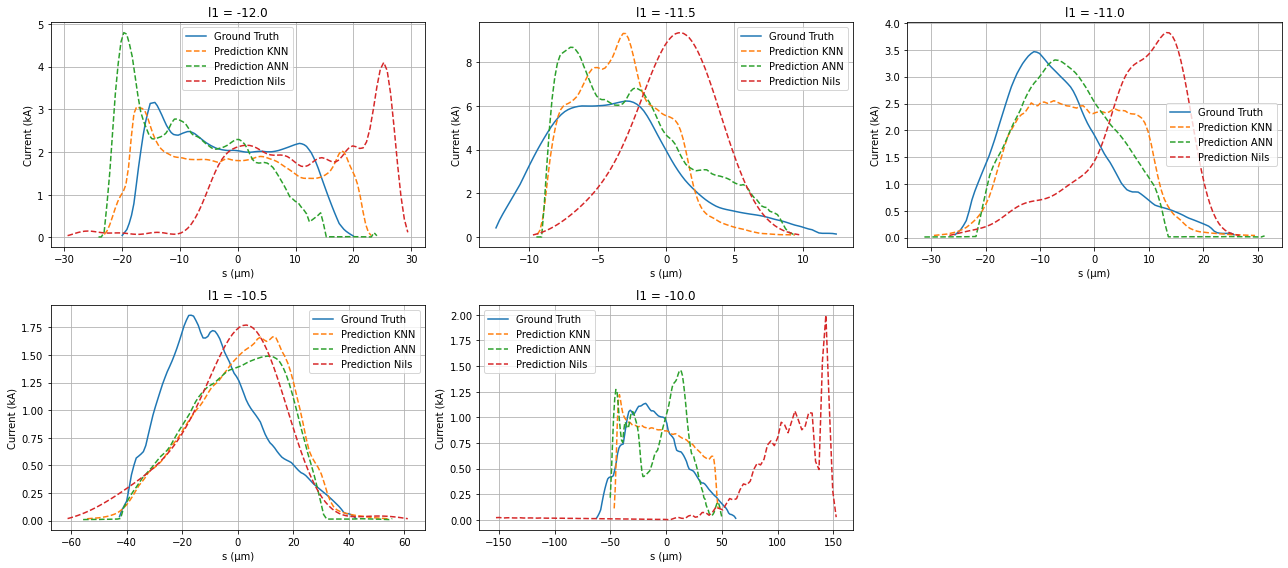

In [96]:
plt.figure(figsize=(18,8))
for i, (l1, truth, prediction) in enumerate(zip(l1s_real, currents_real_centered, real_current_predictions)):
    plt.subplot(2, 3, i+1)
    plt.title(f"l1 = {l1:.1f}")
    plot_prediction(truth, prediction, labels=["KNN","ANN","Nils"])
plt.tight_layout()
plt.show()

In [78]:
l2s_real = []
formfactors_real = []
currents_real = []

tds_mat = sio.loadmat("for_jan/TDS/tds_l2_results.mat")
for l2, current in zip(tds_mat["l2"].astype("float64").squeeze(), tds_mat["currents"].astype("float64").squeeze()):
    paths = glob.glob(f"for_jan/CRISP/formfactor_new_*_*_*_l2_{l2:.1f}.mat")
    assert len(paths) == 1
    
    crisp_mat = sio.loadmat(paths[0])
    
    l2s_real.append(l2)
    formfactors_real.append((
        crisp_mat["frequencies"].astype("float64").squeeze(),
        crisp_mat["formfactors"].astype("float64").squeeze(),
        crisp_mat["formfactors_err"].astype("float64").squeeze(),
        crisp_mat["det_lim"].astype("float64").squeeze(),
        float(crisp_mat["charge"].astype("float64").squeeze())
    ))
    currents_real.append((tds_mat["time"].astype("float64").squeeze()*3e8, current))

In [79]:
formfactors_real_clean = [cleanup_formfactor(freq, ff, ff_noise, detlim, channels_to_remove=[])[:2] for freq, ff, ff_noise, detlim, _ in formfactors_real]

In [80]:
real_current_predictions_knn = knnthz.predict([(freq, ff) for freq, ff in formfactors_real_clean])
real_current_predictions_ann = annthz.predict([(freq, ff) for freq, ff in formfactors_real_clean])
real_current_predictions_nils = np.array([reconstruct_by_nils(*record) for record in formfactors_real])
real_current_predictions = list(zip(real_current_predictions_knn, real_current_predictions_ann, real_current_predictions_nils))

In [81]:
currents_real_centered = center_currents(currents_real)

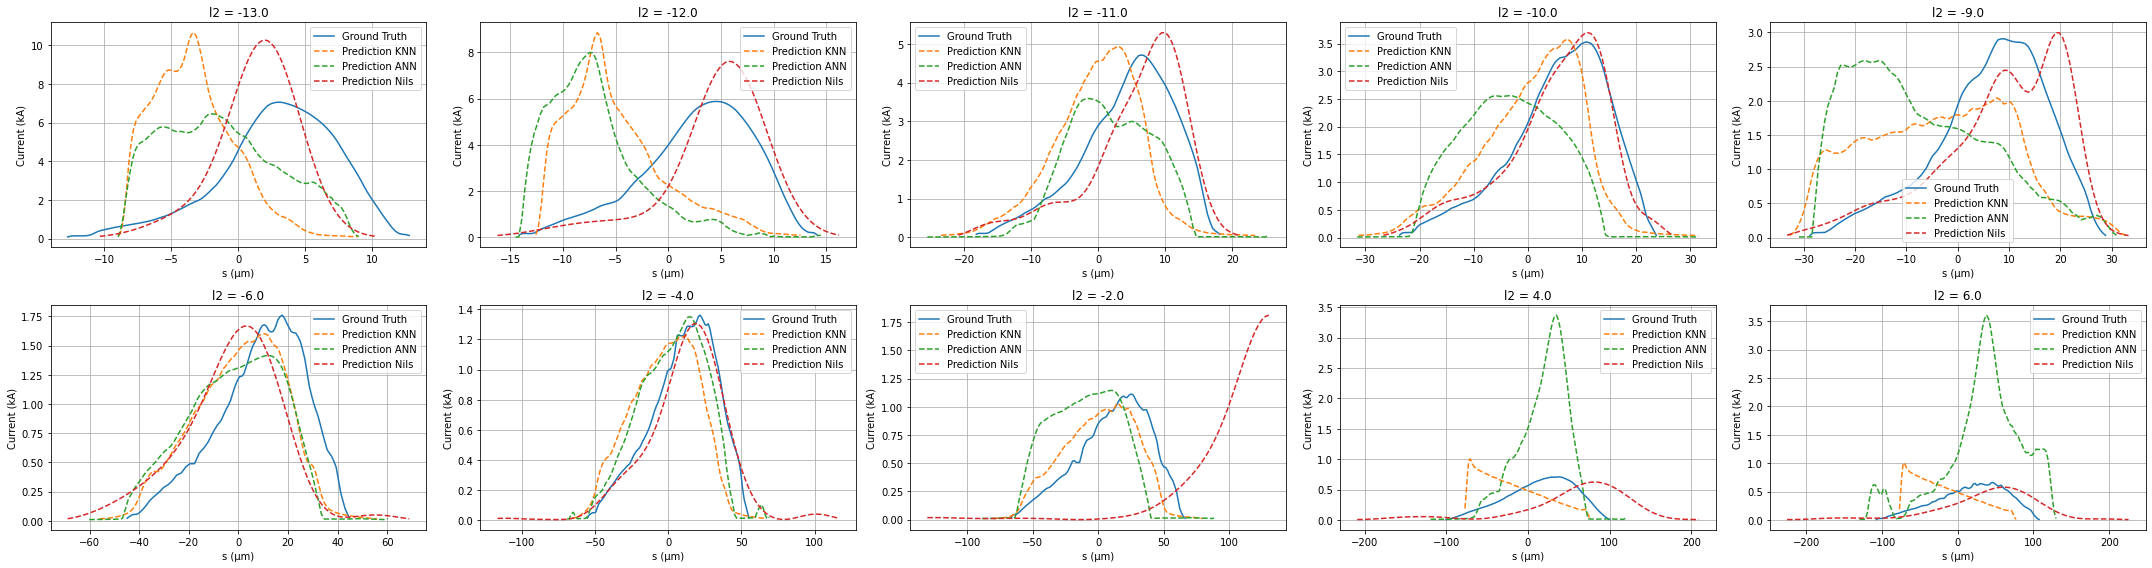

In [82]:
plt.figure(figsize=(30,8))
for i, (l2, truth, prediction) in enumerate(zip(l2s_real, currents_real_centered, real_current_predictions)):
    plt.subplot(2, 5, i+1)
    plt.title(f"l2 = {l2:.1f}")
    plot_prediction(truth, prediction, labels=["KNN","ANN","Nils"])
plt.tight_layout()
plt.show()

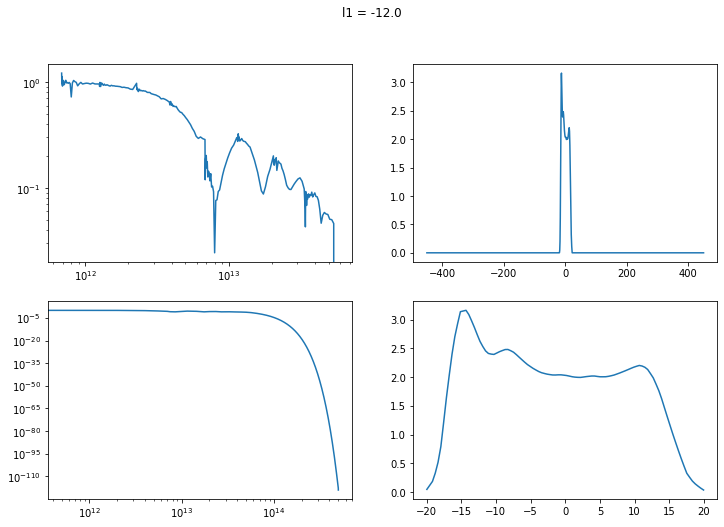

In [49]:
i = 0

plt.figure(figsize=(12,8))
plt.suptitle(f"l1 = {l1s_real[i]}")
plt.subplot(221)
plt.loglog(formfactors_real[0][0], formfactors_real[0][1])
plt.subplot(222)
plt.plot(currents_real[0][0]*1e6, currents_real[0][1]*1e-3)
plt.subplot(223)
plt.loglog(formfactors_real_clean[0][0], formfactors_real_clean[0][1])
plt.subplot(224)
plt.plot(currents_real_centered[0][0]*1e6, currents_real_centered[0][1]*1e-3)
plt.show()